# Creating Views

* Views are virtual tables that are created as a result of a `SELECT` query. 
* They offer a number of advantages, such as showing only a subset of data that is meaningful to users or restricting the number of rows and columns shown for security reasons.
* A view containing columns from multiple tables can simplify queries by changing a multi-table query to a single-table query against a view.
* Views are stored in the database along with tables.
* A view can be created from:
    * a single table,
    * by joining two tables, or
    * from another view.


**SYNTAX**:

```mysql
CREATE [OR REPLACE] VIEW view_name AS
SELECT col1, col2, …coln
FROM table
WHERE <condition>
```

---

**Creating view from a single table. The `SELECT` query specifies the columns in the view.**

```mysql
CREATE VIEW DigitalAssetCount AS 
SELECT ActorId, COUNT(AssetType) AS NumberOfAssets 
FROM DigitalAssets
GROUP BY ActorId;
```

A view can be queried in the same manner as a table.

```mysql
SELECT * FROM DigitalAssetCount;
```

Views are stored as virtual tables and also appear in the list of tables when `SHOW TABLES` is executed.

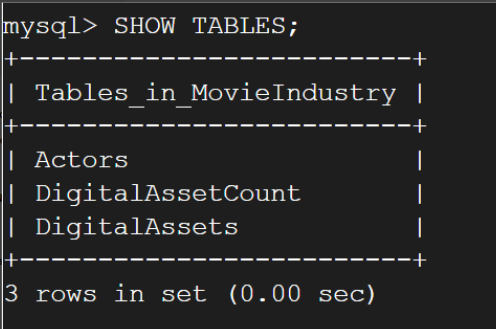

To find out which entities in the above image are tables and which are views, the `SHOW FULL TABLES` command is used. 

The `Table_Type` column in the result specifies whether the object is a view or a table, as shown below:

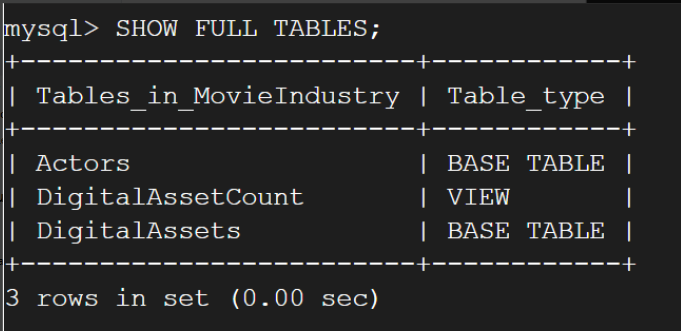

---

**Creating view from multiple tables using JOIN.**

```mysql
CREATE VIEW ActorsTwitterAccounts AS
SELECT FirstName, SecondName, URL
FROM Actors
INNER JOIN DigitalAssets  
ON Actors.Id = DigitalAssets.ActorID 
WHERE AssetType = 'Twitter';
```

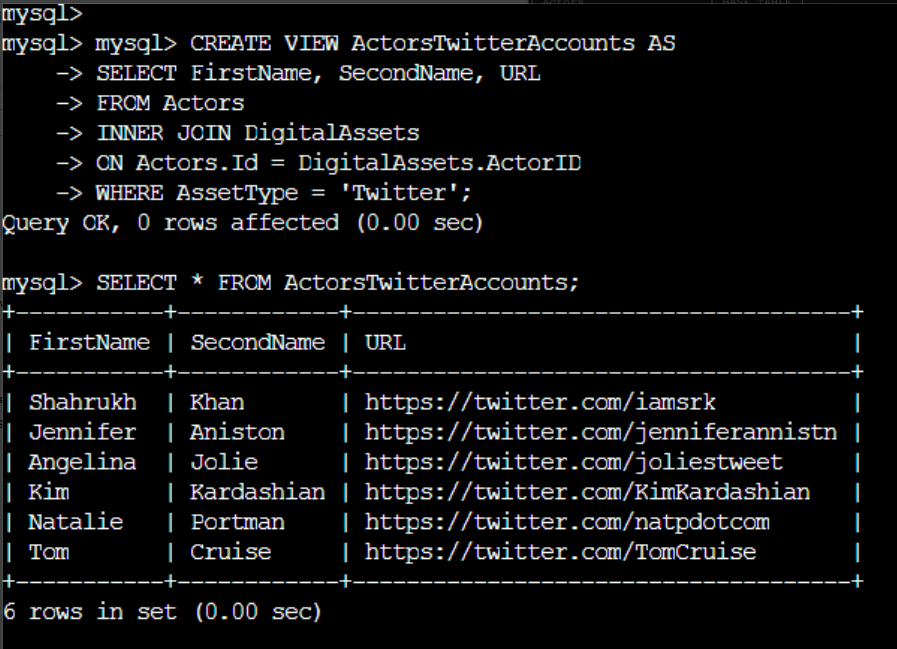

We can use the `[OR REPLACE]` clause to make changes to a view that we just created. If the view does not exist, the `OR REPLACE` clause has no effect.

```mysql
CREATE OR REPLACE VIEW ActorsTwitterAccounts AS
SELECT CONCAT(FirstName, ' ', SecondName) AS ActorName, URL
FROM Actors
INNER JOIN DigitalAssets  
ON Actors.Id = DigitalAssets.ActorID 
WHERE AssetType = 'Twitter';
```

---

**The `SELECT` statement that creates a view can also have a nested subquery.**

```mysql
CREATE VIEW RichActors AS
SELECT FirstName, SecondName, Gender, NetWorthInMillions  
FROM Actors
WHERE NetWorthInMillions > (
SELECT AVG(NetWorthInMillions)
FROM Actors)
ORDER BY NetWorthInMillions DESC;
````

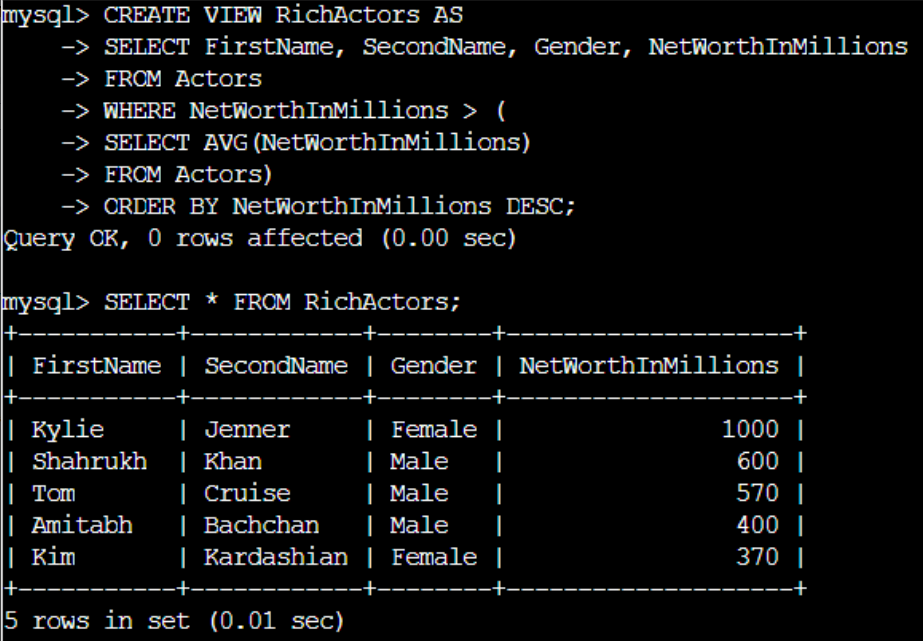

---

**A view can also be created from another view.**

Here, `RichActors` is a view.

```mysql
CREATE VIEW RichFemaleActors AS
SELECT * FROM RichActors
WHERE Gender = 'Female';
```

---

**Explicitly define columns for view.**

```mysql
CREATE VIEW ActorDetails (ActorName, Age, MaritalStatus, NetWorthInMillions) AS
SELECT CONCAT(FirstName,' ',SecondName) AS ActorName, 
    TIMESTAMPDIFF(YEAR, DoB, CURDATE()) AS Age, 
    MaritalStatus, NetWorthInMillions 
FROM Actors;
```

# Updatable Views

* **Views are not only used to query data; they can also be used to update data in the underlying tables.**
* It is possible to insert or update rows in the base table, and in the same view, delete rows from the table using an updatable view.

In order for a view to become updatable, it must abide by certain conditions.
* If the `SELECT` query that creates the view has **aggregate functions** (`MAX`, `MIN`, `COUNT`, `SUM,` etc.), `DISTINCT` keyword, `LEFT JOIN` or `GROUP BY`, `HAVING`, and `UNION` clauses, the resulting view will not be updatable.
* Similarly, a subquery that refers to the same table that appears in the FROM clause prohibits updates to the base table.

**SYNTAX**

```mysql
UPDATE view
SET col1 = value1, col2 = value2,…coln = valuen
WHERE <condition>
```

**EXAMPLE**

```mysql
-- Query 1
CREATE VIEW ActorView AS
SELECT Id, FirstName, SecondName, NetWorthInMillions 
FROM Actors;

-- Query 2
UPDATE ActorView 
SET 
NetWorthInMillions = 250 
WHERE 
Id =1;

-- Query 3
DELETE FROM ActorView
WHERE Id = 11;
```

To find out which views in the database are **updatable**, we can query the **views** table in the `information_schema` database. This table has a column `is_updatable` that indicates the type of view. 

```mysql
-- Query 4
SELECT Table_name, is_updatable
FROM information_schema.views
WHERE table_schema = 'MovieIndustry';
```

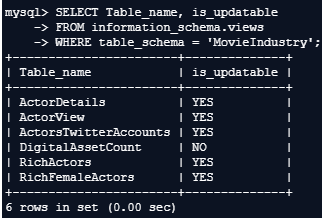


# WITH CHECK OPTION

* Views usually contain a subset of rows from a base table.
* It is possible to insert or update rows that are not visible through the view.
* The `WITH CHECK OPTION` clause is used at the time of creation of the view and is used to maintain consistency when updating a table through an updatable view.
* This clause forbids the user from inserting or updating rows that are not visible through the view.

**SYNTAX**

```mysql
CREATE [OR REPLACE] VIEW view_name AS
select_statement
WITH [LOCAL | CASCADED] CHECK OPTION;
```

---

Suppose we want a view to show details of only those actors who are single.

```mysql
CREATE VIEW SingleActors AS 
SELECT FirstName, SecondName, DoB, Gender, MaritalStatus, NetWorthInMillions 
FROM Actors 
WHERE MaritalStatus = 'Single';
```

This view contains four rows as shown:

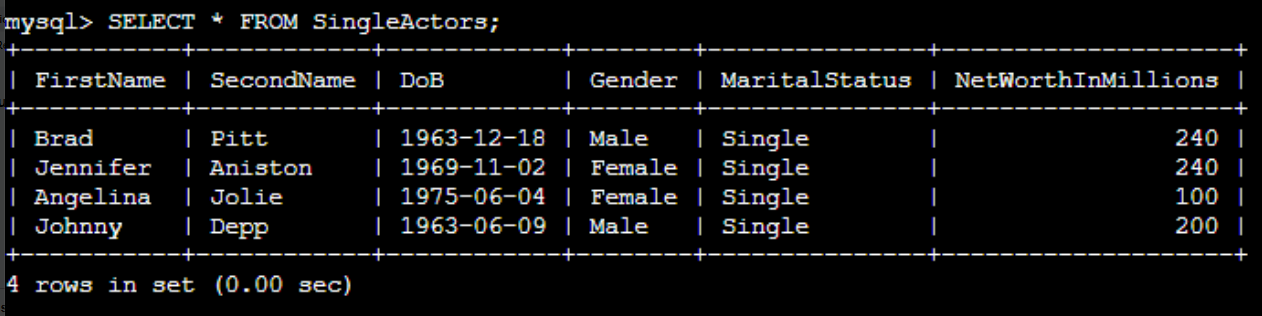

---

Since the **SingleActors** view is updatable, we can insert a row in the Actors table through it. To show the inconsistency that can arise, we will insert a married actor in the table.

```mysql
INSERT INTO SingleActors (FirstName, SecondName, DoB, Gender, MaritalStatus,  NetWorthInMillions) 
VALUES ('Tom', 'Hanks', '1956-07-09', 'Male', 'Married', 350);
```

The insert operation is successful as the row appears in the table.

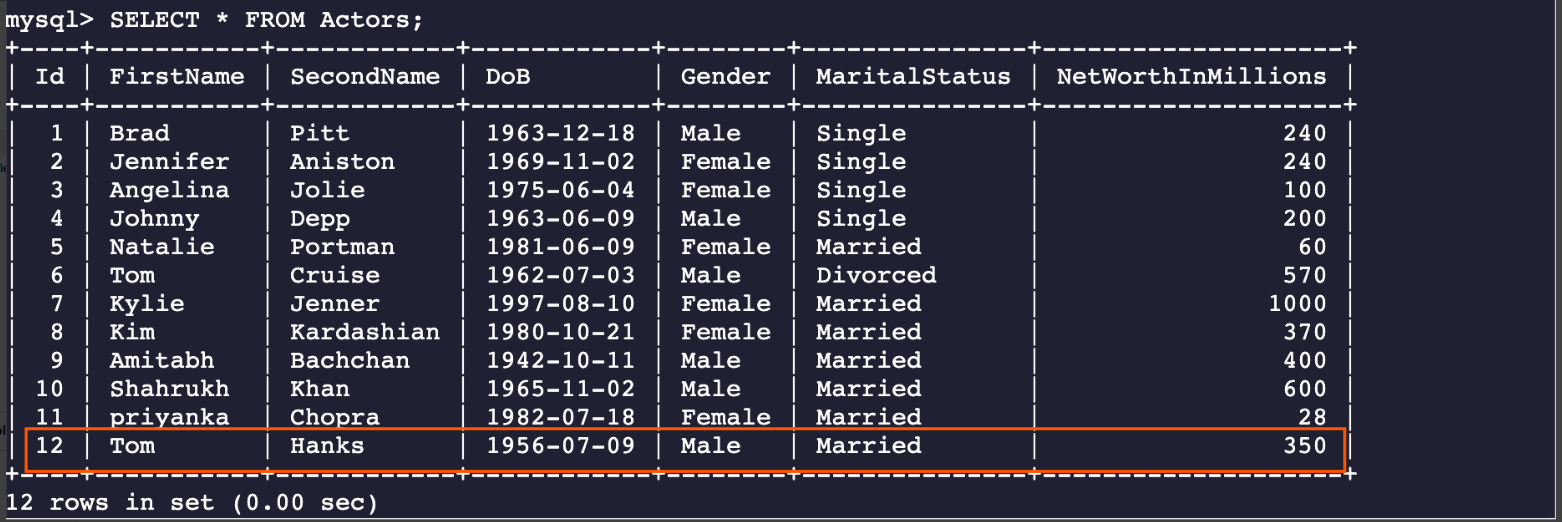

But the newly inserted row doesn’t appear in the **SingleActors** view.

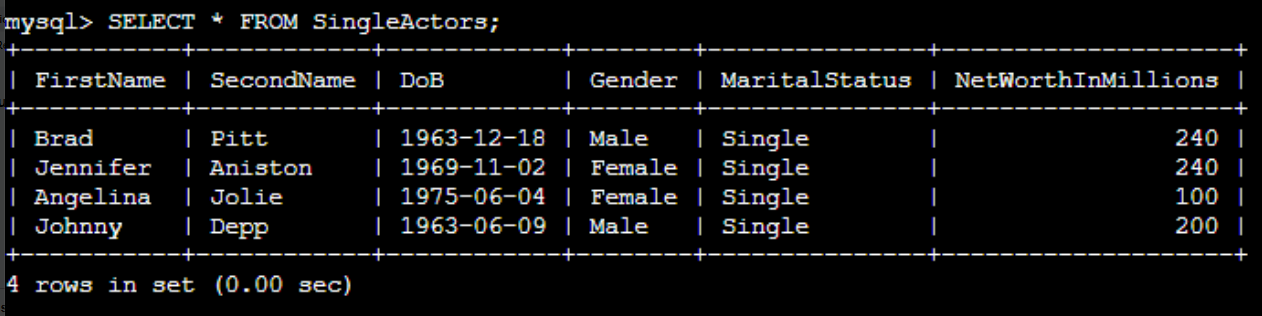

This is because the row we just added does not qualify to appear in the view. 
* The purpose of this view was to display single actors only.
* However, the view can still be used to make unwanted changes to the **Actors** table.

---

The `WITH CHECK OPTION` clause restricts users from updating or inserting data that is not visible through the view. 

```mysql
CREATE OR REPLACE VIEW SingleActors AS 
SELECT FirstName, SecondName, DoB, Gender, MaritalStatus, NetWorthInMillions 
FROM Actors 
WHERE MaritalStatus = 'Single' 
WITH CHECK OPTION;
```

> NOTE: If we omit the `OR REPLACE` clause from the above query, we will get an error because a view with this name already exists.

Now try to insert a row in the Actors table through the **SingleActors** view as follows:

```mysql
INSERT INTO SingleActors (FirstName, SecondName, DoB, Gender, MaritalStatus, NetWorthInMillions) 
VALUES ('Matt', 'Damon', '1970-10-08', 'Male', 'Married', 160);
```

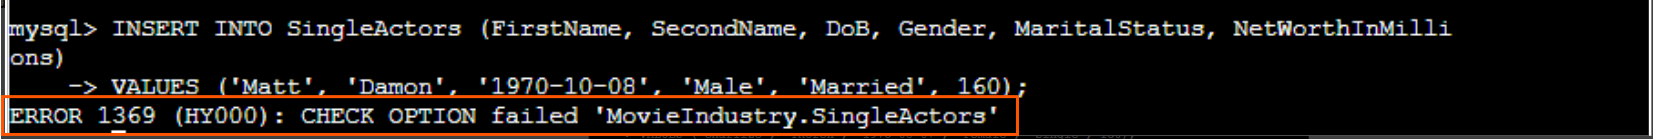

We encounter the `CHECK OPTION` failed error message. The `WITH CHECK OPTION` clause ensures that only actors who are single can be inserted into the Actors table through this view. 

Now execute the following query:

```mysql
INSERT INTO SingleActors (FirstName, SecondName, DoB, Gender, MaritalStatus, NetWorthInMillions) 
VALUES ('Charlize', 'Theron', '1975-08-07', 'Female', 'Single', 130);
```

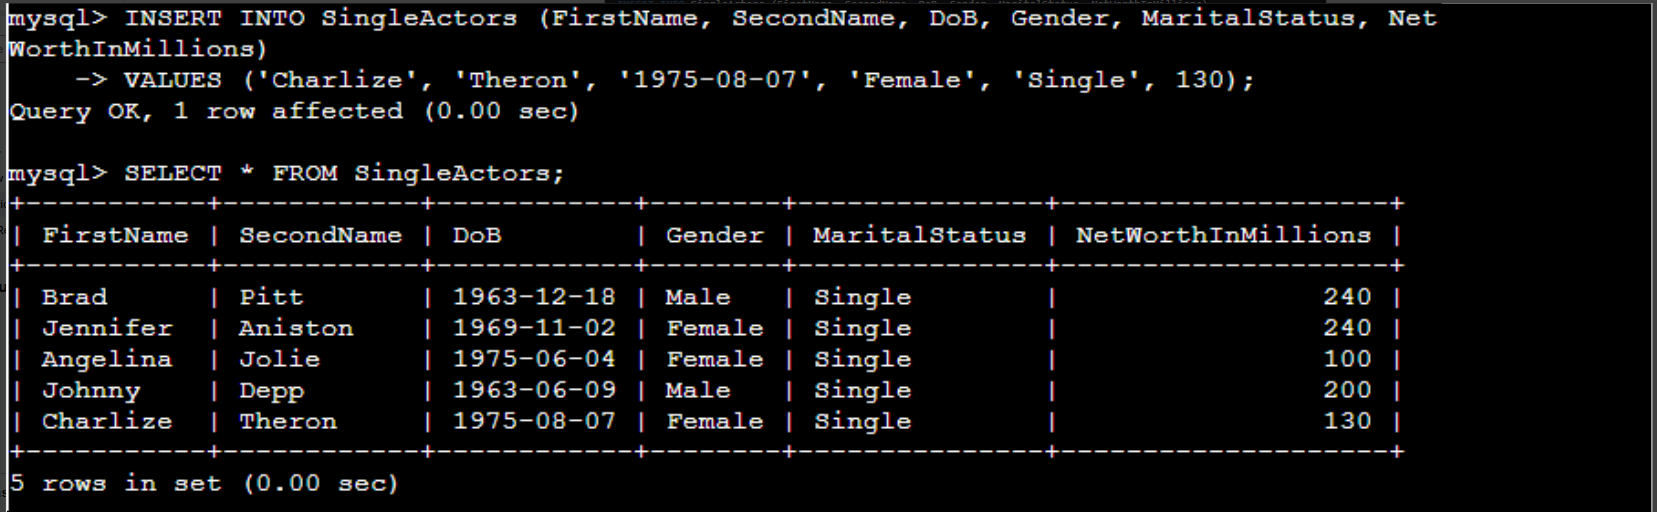

The row is inserted in the table and is visible through the view as well.

## Cascaded CHECK OPTION

**ActorView1**

```mysql
CREATE VIEW ActorsView1 AS
SELECT * 
FROM Actors 
WHERE TIMESTAMPDIFF(YEAR, DoB, CURDATE()) > 40; 
```

Seven rows from the **Actors** table satisfy the `WHERE` clause.

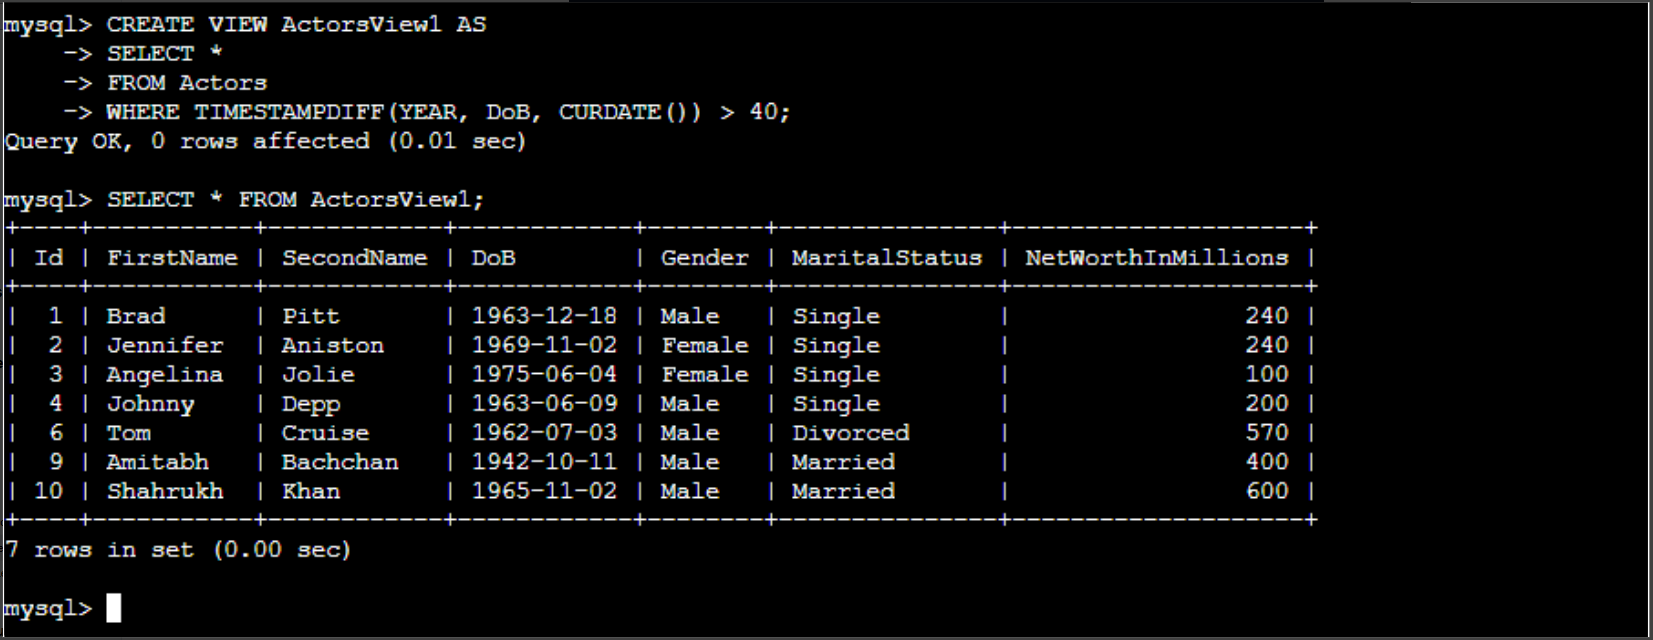

---

Create a view **ActorsView2** based on **ActorsView1** as follows:

```mysql
CREATE OR REPLACE VIEW ActorsView2 AS
SELECT * 
FROM ActorsView1
WITH CASCADED CHECK OPTION; 
```

* Since **ActorsView2** is based on **ActorsView1**, it also has seven rows. 
* The view has a `CASCADED check option` which means that insert or update through **ActorsView2** should not only be compatible with this view but also the underlying view, which is **ActorsView1**.

To see how it works, insert an actor into the Actors table using **ActorsView2** whose age is 20 years.

```mysql
INSERT INTO ActorsView2 VALUES (DEFAULT, 'Young', 'Actor', '2000-01-01', 'Male', 'Single', DEFAULT);
```

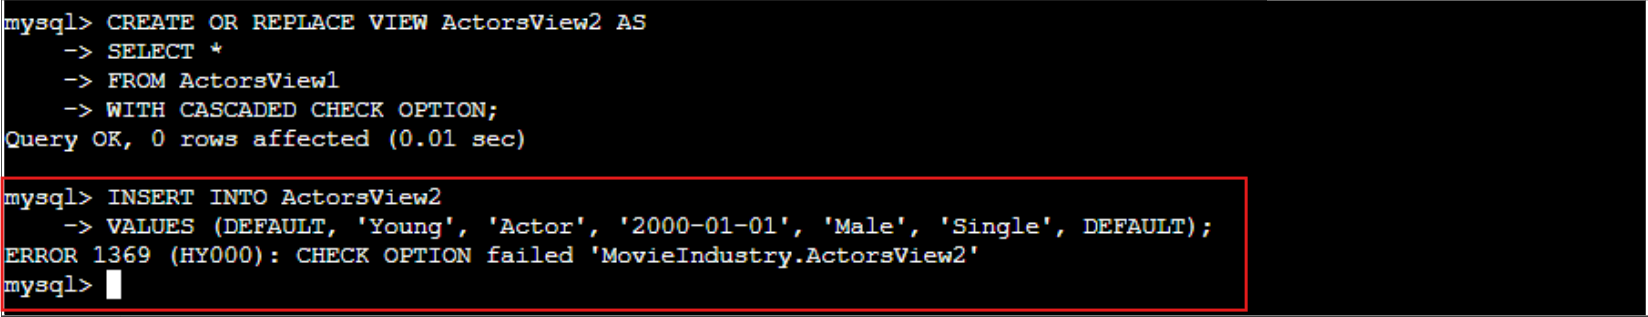

* We encounter an error message, `CHECK OPTION` **failed ‘MovieIndustry.ActorsView2’**.
* The record is not inserted into the **Actors** table even though **ActorsView2** did not impose any age restrictions.
* This is because the `CASCADED CHECK OPTION` clause also tests the rules of the underlying view, **ActorsView1**.
* Since **ActorsView1** only allowed actors who are older than 40 years, and **ActorsView2** is based on **ActorsView1** so we were unable to add a 20-year-old actor.

---

Now we are going to demonstrate the scope of rule testing of the `CASCADED check option`. For this purpose, create a view **ActorsView3** based on **ActorsView2** which should only display actors who are younger than 50.

```mysql
CREATE OR REPLACE VIEW ActorsView3 AS
SELECT * 
FROM ActorsView2
WHERE TIMESTAMPDIFF(YEAR, DoB, CURDATE()) < 50;  
```

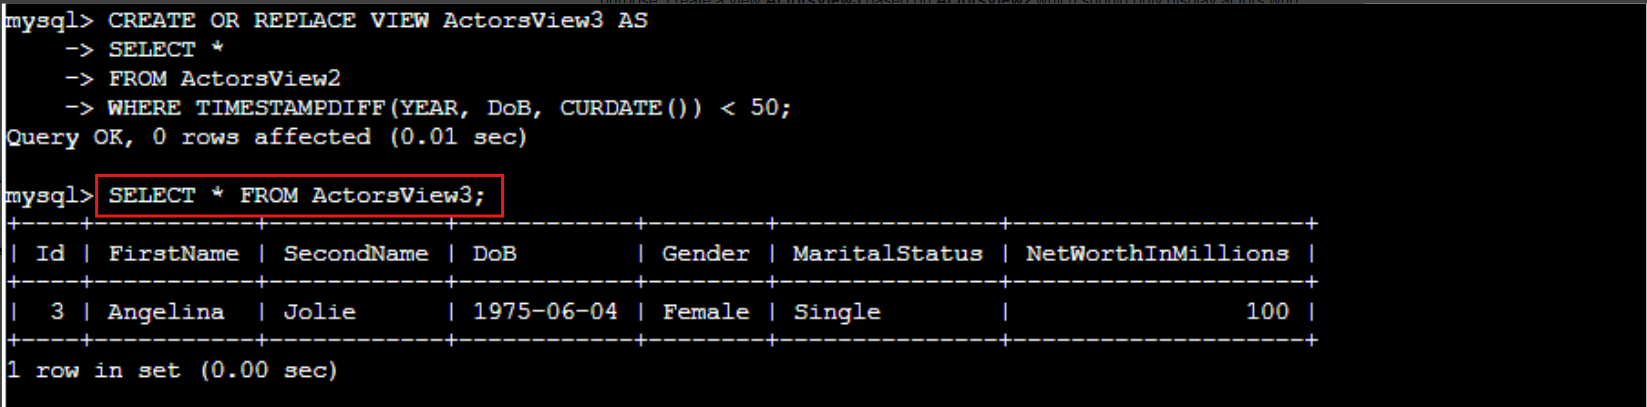

* There is only one row in this view. 
* We should be able to insert a 20-year-old actor through this view, as it satisfies the age < 50 rule.

Try the following query:

```mysql
INSERT INTO ActorsView3 VALUES (DEFAULT, 'Young', 'Actor', '2000-01-01', 'Male', 'Single', DEFAULT);
```

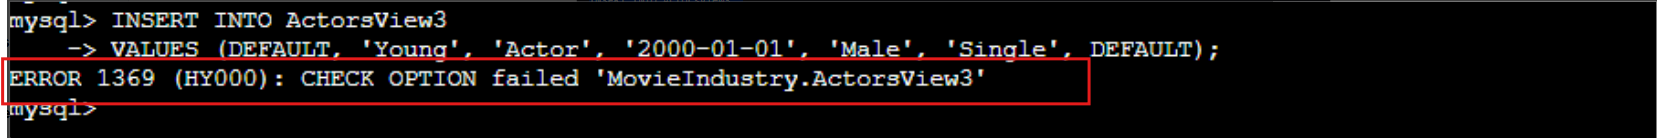

* When executed, we encounter the error, `CHECK OPTION` **failed ‘MovieIndustry.ActorsView3’**.
* This is because the `CASCADED check option` checks the rules of all underlying views before an update is allowed.
* **ActorsView3** is based on **ActorsView2**, and **ActorsView2** is based on **ActorsView1**, which only allows actors older than 40, so we were unable to add a 20-year-old actor through **ActorsView3**.

---

Let’s see if we can insert a 60-year-old actor with this view. Execute the query given below:

```mysql
INSERT INTO ActorsView3 VALUES (DEFAULT, 'Old', 'Actor', '1960-01-01', 'Male', 'Single', DEFAULT);
```

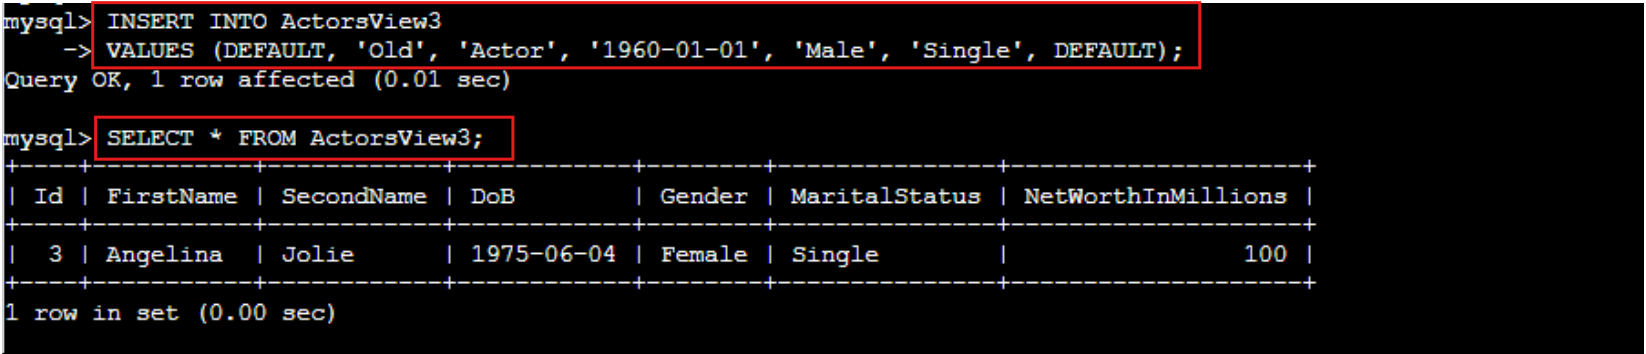

* The insert operation is successful even though an actor whose age is more than 50 years does not comply with the age restriction of **ActorsView3**.
* Since we did not mention the `WITH CHECK OPTION` clause when creating **ActorsView3**, the above insert operation was successful.
* Here, the rules for **ActorsView2** and **ActorsView1** were checked because of the `CASCADED check option`, and the insert was made as the row conforms with the rules of the underlying view (age should be more than 40 years).

> Note that if **ActorsView3** was created using the `WITH CHECK OPTION` clause, then the above insert operation would fail.

The following image gives a pictorial explanation of the effects of using cascaded check option:

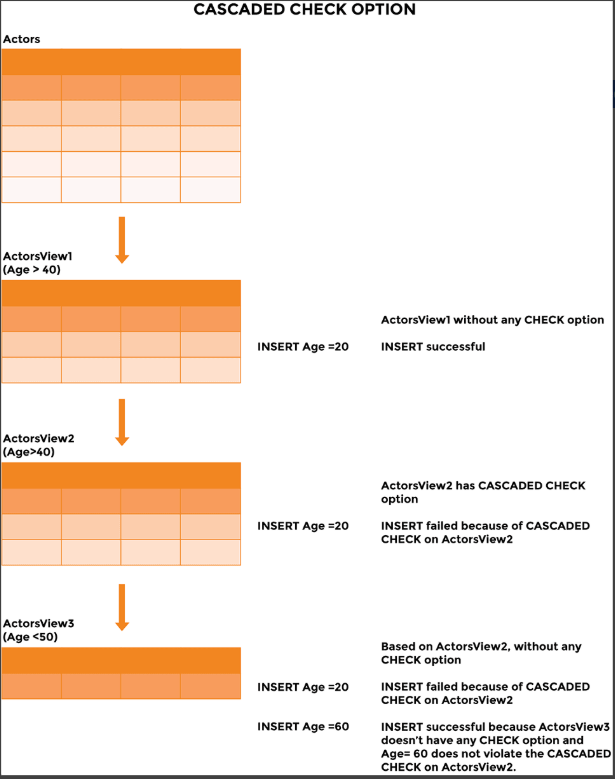

## Local Check

To limit the scope of rule checking let’s redefine ActorsView2 with a LOCAL check option as follows:

```mysql
ALTER VIEW ActorsView2 AS
SELECT * 
FROM ActorsView1
WITH LOCAL CHECK OPTION; 
```

To recap, this view is based on ActorsView1 which shows actors who are older than 40 as shown:

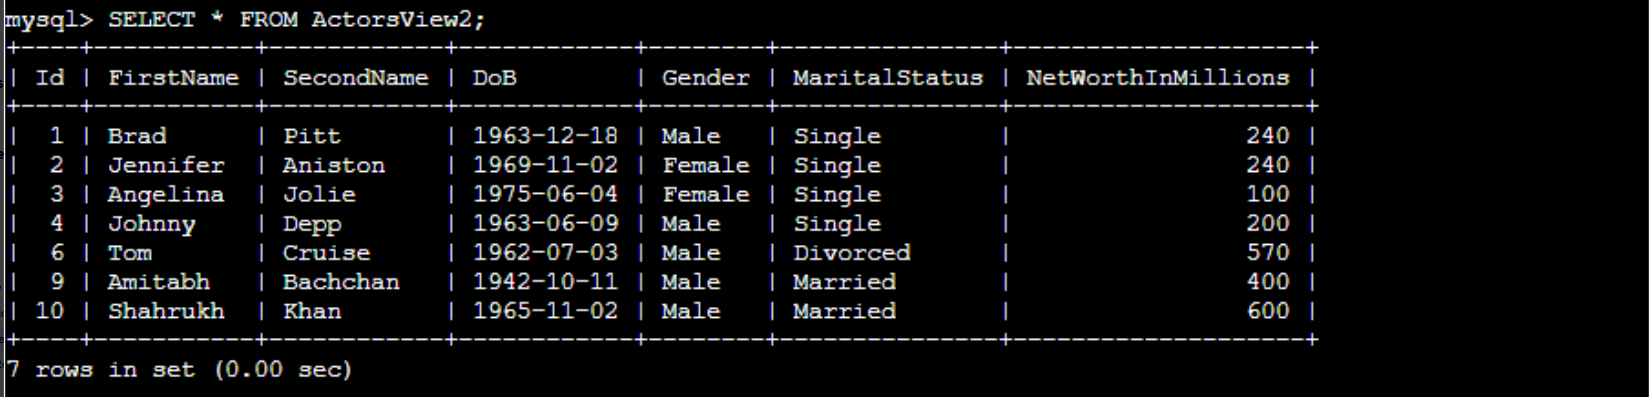

Since ActorsView2 does not specify any age criterion, we can try inserting a 20-year-old actor using this view:

```mysql
INSERT INTO ActorsView2 VALUES (DEFAULT, 'Young', 'Actor', '2000-01-01', 'Male', 'Single', DEFAULT);
```

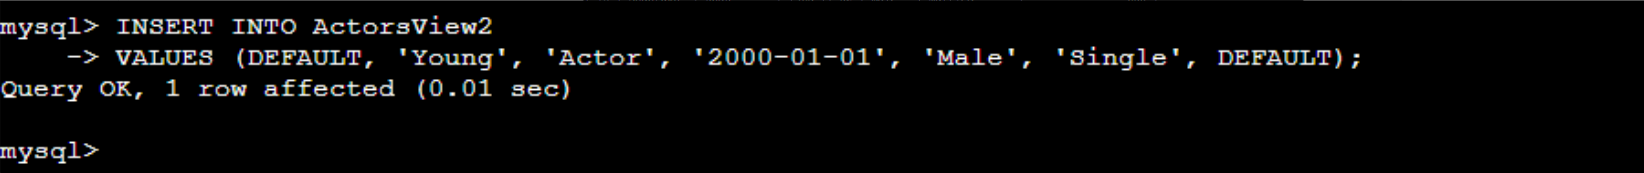

* The row is successfully inserted. `LOCAL check` option in **ActorsView2** means that the insert operation should only conform to the age restriction of **ActorsView2** (none in our case).
* When we used the `CASCADED` check in step 2, we got an error message when the above query was executed, because the rule of the underlying **ActorsView1** was also checked.

However, the row just inserted into the Actors table is not visible through **ActorsView2** because this view only shows actors who are older than 40.

The following image shows the effects of using local check option instead of cascaded check:

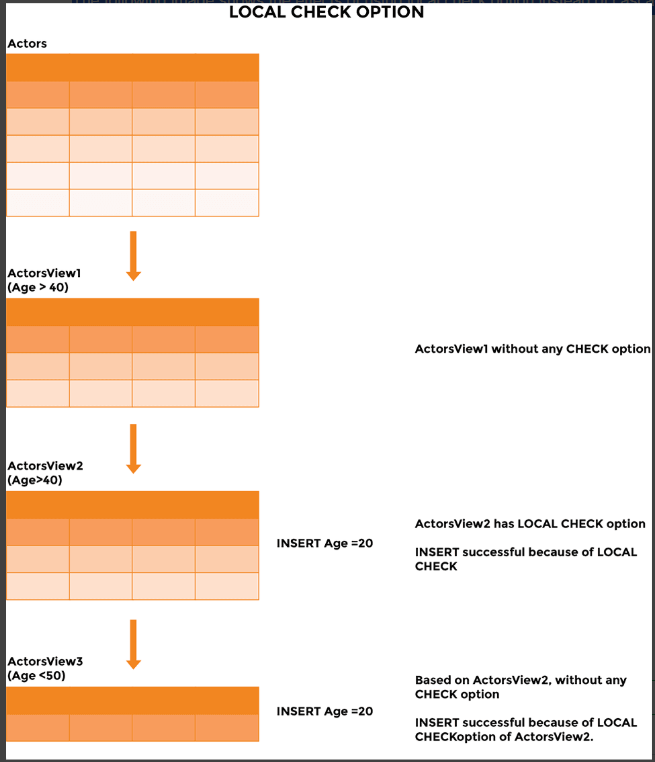

# SHOW, DROP & RENAME Views

There are two ways to list all views in a database:
* One is the **`SHOW FULL TABLES`** command, and
* the other is querying the **`information_schema.views`** database.

The `DROP VIEW` command is used to delete a view from the database.

A view can be renamed in two ways:
* One is by using the `RENAME TABLE` command, and
* the other is by deleting and recreating.

**SYNTAX**

```mysql

SHOW FULL TABLES
{FROM | IN} db_name
WHERE table_type = ‘VIEW’
LIKE pattern;

DROP VIEW [IF EXISTS] view1, view2,…viewn;

RENAME TABLE old_name
TO new_name;

```

---

* We have used the `SHOW TABLES` command to see the views created. 
* Since the tables and views share the same namespace, this command lists both of them.
* The `SHOW FULL TABLES` command used with a `WHERE` clause can be used to show only the views in a database.
* The `FROM | IN` clause is optional and can be used to see the views from another database.

```mysql
SHOW FULL TABLES
WHERE table_type = 'VIEW';
```

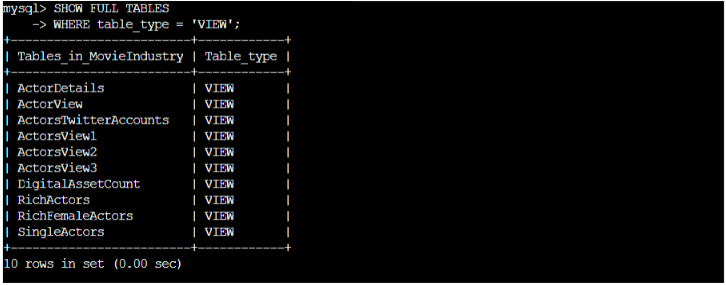

The `LIKE` operator can be used to shortlist views based on a word or pattern.

```mysql
SHOW FULL TABLES
LIKE '%Actor%';
```

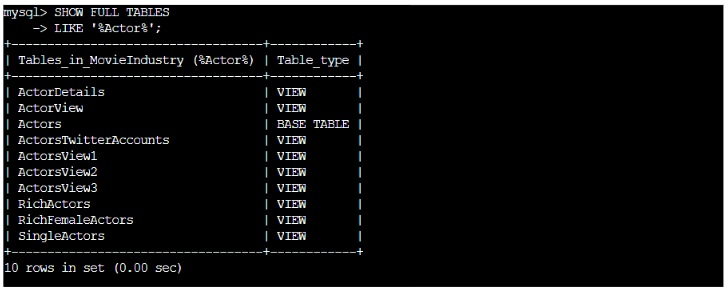

---

The **`information_schema`** database is a catalogue of all MYSQL databases and contains metadata such as database names, tables, privileges, and datatypes of columns, etc. 

A query against this database can also list all views of a particular database as follows:

```mysql
SELECT table_name
FROM information_schema.TABLES
WHERE table_type = 'VIEW'
AND table_schema = 'MovieIndustry';
```

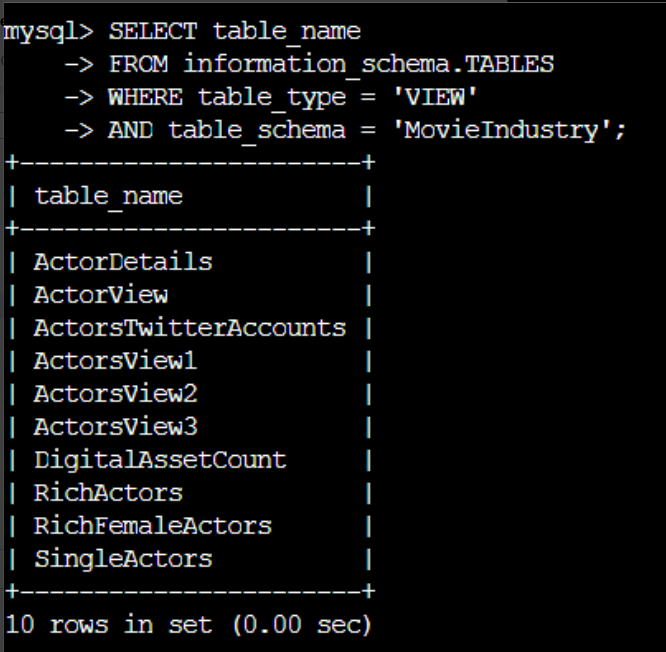

---

* We can delete one or more views at a time using the `DROP VIEW` statement. 
* In the absence of the `IF EXISTS` clause, MYSQL gives an error if the view to be dropped does not exist.
* With this clause, a warning is generated if a view we wish to delete is not found in the database.

```mysql
DROP VIEW DigitalAssetCount, ActorAssets;
```

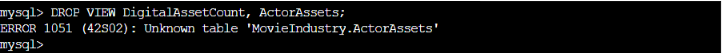

Mysql throws an error message. Re-run the above query with the `IF EXISTS` clause:

```mysql
DROP VIEW IF EXISTS DigitalAssetCount, ActorAssets;
```

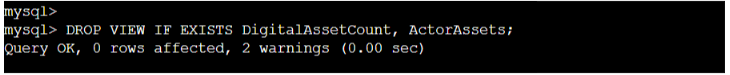

This time, we get a warning and the query is executed as can be seen from the list of views:

---

Views are stored in the same namespace as tables, hence, the `RENAME TABLE` command can be used for renaming views.

```mysql
RENAME TABLE ActorAge
TO ActorsOlderThan50;
```

* There is another method to change the name of a view without using the `RENAME` clause. 
* First, copy the query used to create the view, then drop the view, and lastly create a new one from the DDL copied in the first step.

> NOTE: The `SHOW CREATE VIEW` query is used to show the DDL of the view.